**视频地址**
+ <https://www.bilibili.com/video/BV1t44y1r7ct?p=2>

**jupyter notebook**
+ <https://courses.d2l.ai/zh-v2/assets/notebooks/chapter_convolutional-neural-networks/lenet.slides.html#/>

LeNet(LeNet-5)由两个部分组成，卷积编码器和全连接dense层

In [1]:
import torch
from torch import nn
import d2l_torch as d2l

import os
os.environ["OMP_NUM_THREADS"] = "1"

关于x.view()函数，其实就是对x的浅拷贝，简单来说，就是操作直接加在x上，原地操作。不会产生新的内存空间

# 网络定义

In [2]:
class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,1,28,28)   # 这里相当于把输入的x变成 (batch_size,输入通道，长，宽)，其中batch_size是根据其他几项自动计算的

    
net=torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    # 这里使用的是平均池化
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10))

+ 注意，关于原始图像到底是32还是28，其实不是很重要的，有的是提前padding了，有的是在卷积层才padding。反正大致就是这个意思，实现下来都一样
+ 关于sigmoid函数，如果忘了可以参考：[动手学深度学习V2.0(Pytorch)——10.感知机](https://blog.csdn.net/Castlehe/article/details/120523671)部分搜索sigmoid函数
+ nn.Flatten()，默认是保持第一个维度（最外层的中括号，从左到右数第一个中括号），剩下的拉平
+ pytorch不那么好的地方——Linear层的输入输出需要自己算（自己指明），但是像keras和mxnet这种symbolic的框架就不用算，自动填好的
+ 这里没有在最后一个全连接层加入激活函数，是因为pytorch的交叉熵损失，默认是整合了softmax函数的，所以这里没有在最后一层全连接层加入softmax激活函数

# 检查模型

## 打印模型输出维度信息

In [3]:
net_len=len(net)

In [4]:
# 随便生成一个输入batch看下模型情况
X=torch.rand((1,1,28,28),dtype=torch.float32)
for i,layer in zip(range(net_len),net):
    X=layer(X)
    print(f"{i}.",layer.__class__.__name__,f"output_shape,{X.shape}")
    
# 如果全连接层输入不会算，就直接以这种方式，run一下，然后自己就不用算了。。就可以看到上一个池化层输出的维度，然后就可以自己填进去了

0. Reshape output_shape,torch.Size([1, 1, 28, 28])
1. Conv2d output_shape,torch.Size([1, 6, 28, 28])
2. Sigmoid output_shape,torch.Size([1, 6, 28, 28])
3. AvgPool2d output_shape,torch.Size([1, 6, 14, 14])
4. Conv2d output_shape,torch.Size([1, 16, 10, 10])
5. Sigmoid output_shape,torch.Size([1, 16, 10, 10])
6. AvgPool2d output_shape,torch.Size([1, 16, 5, 5])
7. Flatten output_shape,torch.Size([1, 400])
8. Linear output_shape,torch.Size([1, 120])
9. Sigmoid output_shape,torch.Size([1, 120])
10. Linear output_shape,torch.Size([1, 84])
11. Sigmoid output_shape,torch.Size([1, 84])
12. Linear output_shape,torch.Size([1, 10])


+ 其实0、1、2、3这四部分共同属于一个功能模块，通道从1变成6，高宽减半，所以实际上信息是变多了
+ 4、5、6这三个属于一个组，这一整片的输入其实是(6,14,14)，输出其实是(16,5,5)。也都是通道数增加，长宽减小
+ 然后经过7压平
+ 剩下的几个全连接层其实就是多层感知机（MLP），就是希望通过hidden_size把这个输入的维度逐渐平滑（smooth）的往下降

----
这里卷积层和卷积的激活函数分别作为两层，但是其实可以是一层的，不是很重要。重点是看维度变化。
+ 可以发现，输入其实就是$28\times 28$，经过`2.`的卷积层以及激活函数之后，由于加入了padding，所以即便卷积核是5，也是$28+2\times 2-5+1$=28
+ 然后`4.`这个池化层，其实就是（28+2-2）/2=14，所以输出维度就是14
+ 然后`5.`这个卷积层，就是14-5+1=10,所以输出就是10
+ `7.`这个池化层，就是（10+2-2）/2=5
+ [1,7]层输出的形状，都是(batch_size,channel,length,width)
+ 到了`9.` 其实输入就是16个通道，每个通道的feature map是$5\times 5$，所以就是$16\times 5\times 5=400$，输出大小是自己定的，120（虽然不知道这样的依据是什么，可以自己试验感受一下）
+ `11.`和`13.`同理，

## 模型构造解释

+ 之前在[多输入输出通道中](https://blog.csdn.net/Castlehe/article/details/121844745)讲过
+ 卷积核得到的输出，其实就是识别某种特定的模式，
    + 可以认为，每个输出通道都对应一种特定的模式。即：可以通过学到的卷积核的参数，来匹配出某一个特定的模式。
    + 因此多输出通道的作用就是：每个输出通道都会识别出一个特定的模式
    + 多输入通道的作用就是：输入通道核识别并组合输入中的模式，得到一个组合的模式识别。
+ 因此大部分卷积层，都在不断增大通道数，减小每个通道的大小。这样就可以识别更多的模式
    + 因此，Lenet的卷积部分，也是不断增加输出通道（增加可以识别的模式），减小输出通道的大小
+ 而多层感知机其实就是为了把这部分内容平缓进行压缩，得到最终的分类结果

## 打印模型信息

除了自己直接打印每层，其实也可以直接使用summary函数

+ 如果希望打印的好看一点，那么可以考虑安装一下这个`torchsummary`这个库，然后summary一下。
+ 但是实际上，也不是很有必要，毕竟直接print(model)，也可以啊
+ 参考：[Model summary in pytorch](https://stackoverflow.com/questions/42480111/model-summary-in-pytorch)


```python
    from torchsummary import summary
    summary(net, (3, 224, 224))
```

In [5]:
print(net)

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)


# 查看Lenet在FASHION_MNIST数据集上的表现

因为MNIST基本就是99%，没什么好看的，所以fashion-mnist稍微难一点，所以看这个

In [3]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

## 修改评估函数（适合GPU）

对之前的`evalute_accuracy`函数略微进行修改，添加了对device的判断

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  
    """使用GPU计算模型在数据集上的精度。 把数据挪到device上"""
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device #根据待训练参数存储的位置，来决定使用哪个设备（参数存在cpu，就cpu；GPU，就gpu）
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
            # 如果X是个列表，那就每次挪一个，把数据挪到选择的device上去
        else:
            X = X.to(device)
            # 如果不是列表，只是一个tensor，那就一次挪完
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [8]:
iter(net.parameters())  # 这个其实就是得到一个生成器

<generator object Module.parameters at 0x000001FD1895ADC8>

In [9]:
next(iter(net.parameters()))  # 每次调用，取生成器中的一个对象
# next(iter(net.parameters())).shape # 这个就是第一个卷积层的6个$5\times 5$的卷积核

Parameter containing:
tensor([[[[ 0.0417,  0.0394,  0.0676, -0.1330,  0.1513],
          [-0.0845, -0.0713,  0.0471, -0.0490, -0.1203],
          [ 0.1728, -0.1780,  0.0693,  0.1496,  0.0453],
          [ 0.0168, -0.0760, -0.1282,  0.1465, -0.0787],
          [-0.1050, -0.0625,  0.1855,  0.1090,  0.0756]]],


        [[[ 0.0013,  0.1753, -0.0934,  0.1314,  0.0569],
          [-0.1930, -0.0062, -0.0329,  0.1759, -0.0247],
          [ 0.0856, -0.1015, -0.0843,  0.1265, -0.0739],
          [ 0.1676,  0.1677, -0.0256, -0.0335, -0.1606],
          [-0.1922,  0.1751, -0.1859,  0.0706, -0.1857]]],


        [[[ 0.0639, -0.1705,  0.0711,  0.0757,  0.1477],
          [ 0.1758,  0.1838,  0.1910, -0.0705,  0.1834],
          [-0.1845, -0.1100, -0.0658,  0.0739,  0.1915],
          [-0.1319,  0.0113,  0.1787, -0.1857, -0.0816],
          [-0.0442,  0.0240,  0.1687,  0.0177, -0.1444]]],


        [[[ 0.1391,  0.1642, -0.0902, -0.0307, -0.0510],
          [ 0.1097,  0.1516, -0.0951,  0.1802,  0.0586

为了使用GPU，训练函数也要进行一些改动
+ 关于Xavier初始化，可以参考：[动手学深度学习V2.0(Pytorch)——14. 数值稳定性/模型初始化/激活函数](https://blog.csdn.net/Castlehe/article/details/121076114)
+ 这里也捎带摆了一些激活函数，sigmoid，以及相关的泰勒公式展开，求解

----
**很常见的一种训练错误就是，以为在使用GPU训练，但是实际上，模型的参数压根就没在GPU上**
+ 所以运行之前，一定要用toy数据看看模型运行情况正不正确
+ 打印一下，看看模型参数放在哪里（device是cpu还是gpu）

## 修改训练函数（适合GPU）

In [5]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。   加了一个device参数"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    # 如果是Linear层或者是Conv2d层，那么就使用Xavier进行吃画画
    print('training on', device)
    net.to(device)
    # 把模型参数挪到device上
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            # 这里是对train_iter数据进行挪动
            # 看下面代码，评估准确率是对test_iter数据进行挪动
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec ' f'on {str(device)}')

```python
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

```
可能很多人都忘了这个Accumulator类了，这里贴上去，其实就是对任意对象做累加

另外，这里额外解释下代码中相关的内容（不然都不知道输出的是什么意思）
+ `metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])`，把每个train_iter的损失、准确率、训练样本数量累加。至于这里为什么损失`l`要乘以当前train_iter的样本数，是因为pytorch默认算损失的时候，会直接帮你除以样本数。
+ `train_l = metric[0] / metric[2], train_acc = metric[1] / metric[2]`，当前epoch中所有train_iter的总损失/总样本数量，就是平均损失，同理，就是平均准确率
+ 所以第一个`print`语句就是打印出训练损失，训练准确率以及测试准确率
+ 第二个`print`是（metric[2]是每个epoch中所有的样本数，而timer测得是所有epoch的时间，所以这里就是算每秒可以跑多少个样本，数字越大表示GPU计算速度越快）

## 训练和评估LeNet-5模型

loss 0.457, train acc 0.830, test acc 0.818
5732.1 examples/sec on cpu


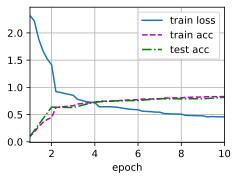

In [6]:
lr,num_epochs=0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

我的电脑没有沐神电脑跑得快，但是跑出来的曲线差不多。
+ 说明神经网络是具有一定的可复现性的，复现出来的性能不会差很多。
+ 我首次运行打印出的信息：
    ```python
    loss 0.471, train acc 0.822, test acc 0.801 
    20190.2 examples/sec on cuda:0 
    ```
+ 老师课上演示的打印信息：
    ```python
    loss 0.463, train acc 0.828, test acc 0.827
    89391.4 examples/sec on cuda:0 
    ```
+ 同时可以观察到，
    + 训练和测试集的准确率曲线基本是重合的，没有over-fitting。
    + 那说明就是under-fitting，说明这个模型不够强。
    + 可以考虑多训练一段时间，但是可以看到基本上epoch6之后，曲线已经很平滑的，所以可能增加训练轮数，意义不是很大
+ 另外，在时间上，一共就5w个样本，所以如果我的电脑每秒是2w样本，其实很快就能跑完，但是感觉上还跑了挺久，是因为还有画图等其他的开销。所以整体被拖慢了，其实计算还是挺快的

---
略微调一下参数，评论区有人说，调到0.873咧

loss 0.363, train acc 0.865, test acc 0.764
23107.7 examples/sec on cuda:0


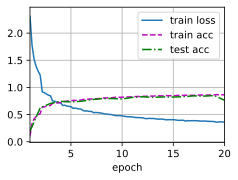

In [56]:
lr,num_epochs=0.8,20
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

loss 0.352, train acc 0.868, test acc 0.846
20051.7 examples/sec on cuda:0


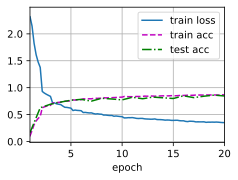

In [58]:
lr,num_epochs=1,20
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

+ 玄学，0.868，看起来差不多了。单纯靠调节两个参数，感觉不是那么有效咧，可能还是要动动网络结构。
+ 而且按照老师的说法，这个很容易调节到0.84,0.83的样子，那就差不多了

## 预测可视化一下结果

+ 一开始报错对`preds=`这句报错，`RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same`
    + 很明显，输入X是在cpu上的，而权重weight是在cuda上的
    + 所以加入下面这两句代码，把东西挪到gpu上
    ```python
    X=X.to(d2l.try_gpu())
    y=y.to(d2l.try_gpu())
    ```
+ 但是，改了之后又报错了，`TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.`
    + 简单来说，画图的时候要用cpu啊，所以还是要再搬一次。。
+ 所以一开始应该是把网络从gpu里搬到cpu，`    net=net.to("cpu")`。这样就不会报错了，就可以画出来了

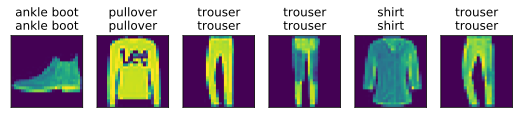

In [72]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
#     X=X.to(d2l.try_gpu())
#     y=y.to(d2l.try_gpu())
    net=net.to("cpu")
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

86的准确率，看起来还是挺高的

## 与MLP相比

MLP部分，点击[这里](https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/mlp-concise.html)
+ MLP效果看起来是稍微好一点
+ 但是MLP的过拟合情况比LeNet要严重一点，因为后者参数量要小很多

比较参数量计算：

```python
# MLP网络
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))
```
+ (784\*256)+(256\*10)=203264

```python
# LeNet-5
net=torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    # 这里使用的是平均池化
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10))
```

+ (6\*5\*5)+(6\*16\*5\*5)+(16\*5\*5\*120)+(120\*84+84\*10)=61470

----
可以看到，这个参数量差了将近3倍，所以卷积层（受限的全连接层），其实还是有点用的。。

In [55]:
784*256+256*10,6*5*5+6*16*5*5+16*5*5*120+120*84+84*10

(203264, 61470)

# 自己尝试修改

## 激活函数换relu

In [47]:
net_relu_tanh=torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    # 这里使用的是平均池化
    nn.Conv2d(6,16,kernel_size=5),nn.Tanh(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10))

loss 0.530, train acc 0.805, test acc 0.793
20488.1 examples/sec on cuda:0


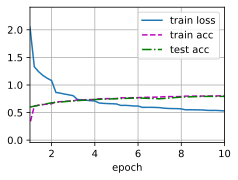

In [48]:
lr,num_epochs=0.01,10
train_ch6(net_relu_tanh,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

+ 如果全部使用ReLU的话，确实很难收敛。。。看下图
    + 但是lr改小之后，损失变成2.5以下的，之前图的y轴刻度都是2.5以上开始的
    + 不管是损失还是准确率曲线，基本一致是横线的，不会发生改变。
    + 另外，如果使用了Relu，lr一定要很小，不然就容易出错
    + 有时候压根无法收敛，有时候还勉强可以收敛，看运气
+ 但是如果把中间第二个卷积层的激活函数改成，tanh()，看上面，其实和使用sigmoid就差不多了
    + 所以这个东西确实有点玄学，总不见得把中间计算过程全都打印出来？？？
    + 一点点数据的看？？

纯ReLU

In [21]:
net_relu=torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    # 这里使用的是平均池化
    nn.Conv2d(6,16,kernel_size=5),nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*5*5,120),nn.ReLU(),
    nn.Linear(120,84),nn.ReLU(),
    nn.Linear(84,10))

loss 0.537, train acc 0.799, test acc 0.775
5717.4 examples/sec on cpu


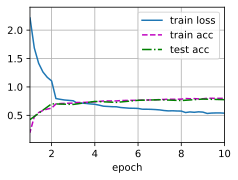

In [23]:
lr,num_epochs=0.01,10
train_ch6(net_relu,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

In [39]:
torch.set_printoptions(precision=3,sci_mode=False)

In [40]:
print(net[1].weight)

Parameter containing:
tensor([[[[     0.946,     -0.440,     -0.717,     -0.471,      0.624],
          [     0.809,     -0.353,     -1.468,     -1.121,      0.325],
          [     0.901,     -0.548,     -1.619,     -1.245,      0.264],
          [     1.398,     -0.277,     -1.242,     -0.833,      0.606],
          [     1.595,      0.009,     -0.830,     -0.322,      0.992]]],


        [[[     0.665,     -0.016,     -0.498,     -0.017,      1.001],
          [     0.331,     -0.793,     -1.340,     -0.663,      0.642],
          [     0.392,     -1.096,     -1.613,     -0.823,      0.221],
          [     0.775,     -0.710,     -1.331,     -0.634,      0.696],
          [     0.855,     -0.208,     -0.817,     -0.136,      1.247]]],


        [[[    -1.183,     -0.379,      0.190,      0.765,      0.258],
          [    -1.145,     -0.251,      0.284,      0.743,      0.371],
          [    -0.906,     -0.089,      0.722,      1.153,      0.379],
          [    -1.092,     -0.217,

## 尝试修改网络结构

可视化结果之后，感觉可以把padding改改，或者对池化层做一些改动，感觉还可以变得更好，试试。

In [16]:
net_self=torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=4),nn.ReLU(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    # 这里使用的是平均池化
    nn.Conv2d(6,16,kernel_size=5),nn.Tanh(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*6*6,240),nn.ReLU(),
    nn.Linear(240,80),nn.ReLU(),
    nn.Linear(80,10))

In [17]:
# 随便生成一个输入batch看下模型情况
net_len=len(net_self)
X=torch.rand((1,1,28,28),dtype=torch.float32)
for i,layer in zip(range(net_len),net_self):
    X=layer(X)
    print(f"{i}.",layer.__class__.__name__,f"output_shape,{X.shape}")

0. Reshape output_shape,torch.Size([1, 1, 28, 28])
1. Conv2d output_shape,torch.Size([1, 6, 32, 32])
2. ReLU output_shape,torch.Size([1, 6, 32, 32])
3. AvgPool2d output_shape,torch.Size([1, 6, 16, 16])
4. Conv2d output_shape,torch.Size([1, 16, 12, 12])
5. Tanh output_shape,torch.Size([1, 16, 12, 12])
6. AvgPool2d output_shape,torch.Size([1, 16, 6, 6])
7. Flatten output_shape,torch.Size([1, 576])
8. Linear output_shape,torch.Size([1, 240])
9. ReLU output_shape,torch.Size([1, 240])
10. Linear output_shape,torch.Size([1, 80])
11. ReLU output_shape,torch.Size([1, 80])
12. Linear output_shape,torch.Size([1, 10])


loss 0.793, train acc 0.715, test acc 0.706
3615.8 examples/sec on cpu


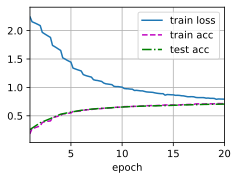

In [18]:
net_self=torch.nn.Sequential(
    Reshape(),nn.Conv2d(1,6,kernel_size=5,padding=4),nn.Tanh(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Tanh(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*6*6,240),nn.Tanh(),
    nn.Linear(240,80),nn.ReLU(),
    nn.Linear(80,10))
lr,num_epochs=0.001,20
train_ch6(net_self,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

loss 0.393, train acc 0.860, test acc 0.849
3643.8 examples/sec on cpu


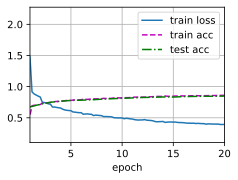

In [19]:
lr,num_epochs=0.01,20
train_ch6(net_self,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

loss 0.334, train acc 0.880, test acc 0.866
3666.9 examples/sec on cpu


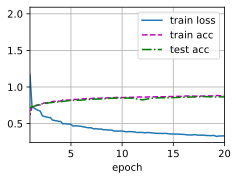

In [20]:
lr,num_epochs=0.02,20
train_ch6(net_self,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

瞎几把改了之后，输出信息为：
```python
loss 0.334, train acc 0.880, test acc 0.866
3666.9 examples/sec on cpu
```

+ 比弹幕里的人还要高，开心，虽然不确定这个东西稳定不稳定。
+ 目前看下来，没有十分过拟合，整体感觉还是不错的，
+ 如果训练时间再长一点，说不定会更好一些。现在已经很满意咧

# 其他

## MNIST图像表示

这个部分其实来自于fast.ai
+ [Understanding fastai's Applications: Digit classifier using fastai framework.](https://aymene.hashnode.dev/understanding-fastais-applications-digit-classifier-using-fastai-framework)
+ [Issue with pd.Dataframe MNIST](https://forums.fast.ai/t/issue-with-pd-dataframe-mnist/67933)
+ 感谢：[neural_network_pytorch.ipynb](https://colab.research.google.com/github/bipinKrishnan/ML_from_scratch/blob/master/neural_network_pytorch.ipynb#scrollTo=nwG5o5qj2dVx)
    + 完全可以实现不借助 fast.ai就得到这种图像展示
    

**注意，如果希望使用df来显示图像，那么图像必须是单通道（只能有两个维度，就是长和宽，不能有通道。。因为就一个平面图）**

-----
+ 另外发现，df显示表格也是可以有花样的，参考：[Table Visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)


In [24]:
from PIL import Image
import pandas as pd
import numpy as np

# Display as text
img=Image.open("../../img/im3.jpg")
print(type(img))
df = pd.DataFrame(np.array(img))
df.style.set_properties(**{'font-size':'4pt'}).background_gradient('Greys')

<class 'PIL.JpegImagePlugin.JpegImageFile'>


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,1,0,0,0,4,2,0,0,13,0,0,0,9,0,8,0,0,0,0,1,11,0,5,0,0,0,0
1,8,3,0,0,2,0,0,7,6,0,3,12,1,0,0,0,0,4,2,4,0,3,0,0,0,0,0,0
2,0,3,0,0,12,3,0,9,12,0,0,0,1,11,16,4,0,0,0,7,0,6,12,9,0,0,0,0
3,0,11,0,0,3,3,0,0,0,18,7,1,0,0,0,0,4,0,0,9,0,0,0,0,0,0,0,0
4,2,4,0,0,8,7,1,10,0,0,0,0,6,0,0,0,11,0,0,1,6,2,11,8,0,0,0,0
5,6,0,0,13,8,0,0,0,5,38,159,195,249,249,255,173,181,150,110,9,0,0,0,0,0,0,0,0
6,7,0,4,5,0,0,35,47,165,213,255,240,226,215,244,255,255,251,206,6,0,0,8,13,0,0,0,0
7,0,0,12,0,0,105,222,248,245,199,36,21,10,1,6,193,241,255,242,0,0,6,1,0,0,0,0,0
8,5,0,4,0,3,115,234,255,233,43,0,2,0,12,0,193,250,254,153,0,0,4,0,5,0,0,0,0
9,0,0,10,9,0,10,39,25,12,21,0,1,6,0,46,229,253,252,73,0,14,0,0,0,0,0,0,0
